# Mapping HERA's Primary Beam
## Tyler Cox

This notebook is being used to study the shape of HERA's primary beam, that is, the sensitivity of HERA as a function of angle from the zenith. We'll start by importing all of the necessary packages.

In [29]:
from astropy.io import fits
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from HERA_calibration_sources import add_fluxes
from pyuvdata import UVBeam
import healpy as hp
import time

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')

Now, we need to pull in the data from the images that we've already generated. To do this, the glob package is used to search for all of the fits files we need to do the mapping. For now, we'll look at sources that we imaged in the 110-120 MHz range. Once glob collects the files, they are sorted, opened, and added to a list for later use

In [19]:

file_groups = ['110-120MHz','120-130MHz','130-140MHz','140-150MHz','150-160MHz','160-170MHz','170-180MHz','180-190MHz']


def open_fits(files):
    '''
    Opens a fits file(s) and returns an HDU object
    '''
    HDUS = []
    files = np.array(files)
    for f in files:
        HDUS.append(fits.open(f))
    return HDUS

groups = []

for group in file_groups:
    files = np.sort(glob('/data6/HERA/HERA_imaging/IDR2/' + group + '/imgs/*fits'))
    HDUS = open_fits(files)
    groups.append(HDUS)

In [21]:
groups = np.array(groups)
print groups.shape

(8, 276, 1)


We then use the HERA_calibration_sources package to find bright sources within our field of view which we will track and use to 

In [22]:
tb = add_fluxes(RA_range=('00:00:00','13:00:00'),dec_range=15, min_flux=6)


Right ascension:
	Lower: 00h00m00s 
	Upper: 13h00m00s
Declination:
	Lower: -45.7214 degrees
	Upper: -15.7214 degrees
Minimum flux: 6 Jy
Number of regions found: 211

               Name of Center          RA        Dec  Total flux in region
0    TGSSADR J001030.5-442258    2.627240 -44.382790          18163.699585
1    TGSSADR J000601.8-423442    1.507820 -42.578468          12856.000374
2    TGSSADR J000313.4-355640    0.806150 -35.944519           9645.399803
3    TGSSADR J001217.9-332159    3.074900 -33.366611           8745.699898
4    TGSSADR J000321.9-172712    0.841650 -17.453360          17756.700588
5    TGSSADR J003826.8-385948    9.611930 -38.996681          16425.900238
6    TGSSADR J001524.2-380436    3.850850 -38.076740          18754.700014
7    TGSSADR J002530.4-330346    6.376880 -33.062962          12610.299990
8    TGSSADR J002430.1-292848    6.125430 -29.480061          20084.700779
9    TGSSADR J002549.1-260210    6.454840 -26.036301          19164.000778
10   TGS

In [50]:
err = 3
deg_prec = 0.5

tracks = []
track_pos = []
tracks_gridded = []
tracks_gridded_ang = []
tracks_gridded_std = []

start = time.time()

for c, freq_group in enumerate(file_groups):
    print 'Starting Frequency Group:', file_groups[c]
    flux = []
    pos = []
    files = np.sort(glob('/data6/HERA/HERA_imaging/IDR2/' + freq_group + '/imgs/*fits'))
    
    for f in files:
        with fits.open(f) as HDU:
            
            # Read in file information
            fits_info = HDU[0].header
            ax1        = fits_info['NAXIS1']
            ax2        = fits_info['NAXIS2']
            units      = fits_info['BUNIT']
            c_ra       = fits_info['OBSRA']
            c_dec      = fits_info['OBSDEC']
            pix_size   = fits_info['CDELT2']
            c_pix1     = fits_info['CRPIX1']
            c_pix2     = fits_info['CRPIX2']

            data = HDU[0].data
            data = np.flip(data[0][0],axis=0)

            w = WCS(f)
            
            for _,src in tb.iterrows():
                # Convert a position to pixel values
                i,j = w.all_world2pix(src['RA'],src['Dec'],0,0,0)[:2]
                try:
                    i = int(i)
                    j = int(ax2-j)
                except:
                    pass

                if (c_ra+deg_prec > src['RA'] > c_ra-deg_prec):
                    flux.append(np.abs(data[j-err:j+err,i-err:i+err]).sum()/src['Total flux in region'])
                    pos.append(src['Dec'])
    
    flux = np.array(flux)
    pos = np.array(pos) 
    
    # Gridding Process
    
    sort_pos = np.copy(pos)
    sort_pos.sort()
    sort_pos = sort_pos.round()
    gridding_ang = np.arange(sort_pos.min(),sort_pos.max()+1)
    gridding_flux = np.zeros(gridding_ang.shape[0])
    gridding_std = np.zeros(gridding_ang.shape[0])
    
    for k,val in enumerate(gridding_ang):
        idx = np.where(pos.round() == val)[0]
        gridding_flux[k] = np.mean(flux[idx])
        gridding_std[k] = np.std(10*np.log10(flux[idx]))
        
    # Estimating Remaining Time
    
    remaining_time = (time.time()-start)/(c+1)*(len(file_groups)-c+1)
    print 'Estimated time remaining:', remaining_time/60, 'minutes'
    
    # Storing all of the data
    
    tracks.append(flux)
    track_pos.append(pos)
    tracks_gridded.append(gridding_flux)
    tracks_gridded_ang.append(gridding_ang)
    tracks_gridded_std.append(gridding_std)

Starting Frequency Group: 110-120MHz
Estimated time remaining: 7.67782108784 minutes
Starting Frequency Group: 120-130MHz
Estimated time remaining: 7.55564799309 minutes
Starting Frequency Group: 130-140MHz
Estimated time remaining: 6.93860906627 minutes
Starting Frequency Group: 140-150MHz
Estimated time remaining: 6.04435412288 minutes
Starting Frequency Group: 150-160MHz
Estimated time remaining: 4.6782777826 minutes
Starting Frequency Group: 160-170MHz
Estimated time remaining: 3.93292094337 minutes
Starting Frequency Group: 170-180MHz
Estimated time remaining: 2.83078640699 minutes
Starting Frequency Group: 180-190MHz
Estimated time remaining: 1.92553429504 minutes


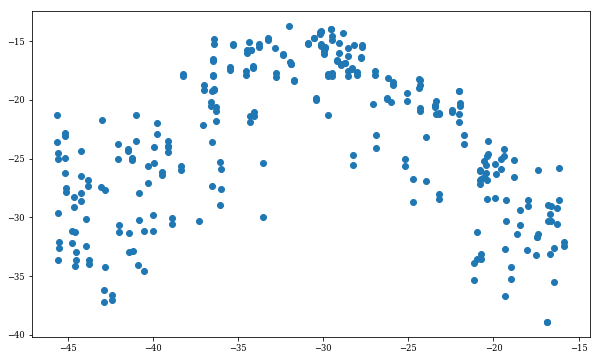

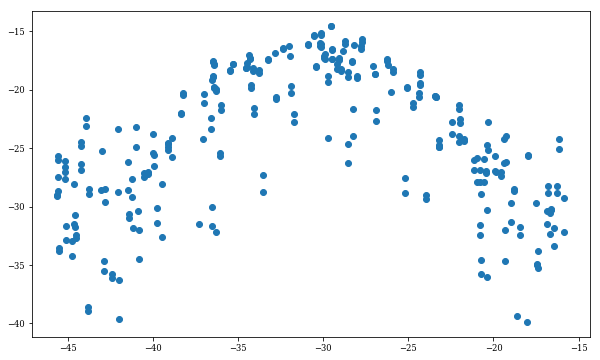

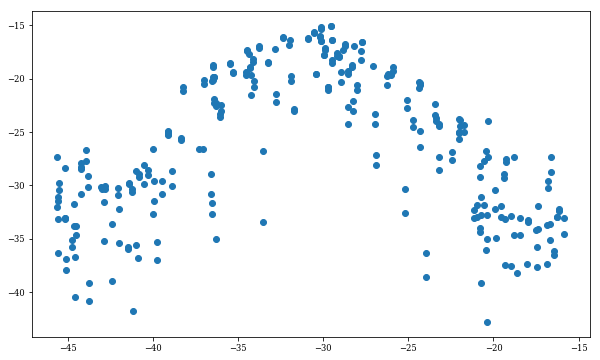

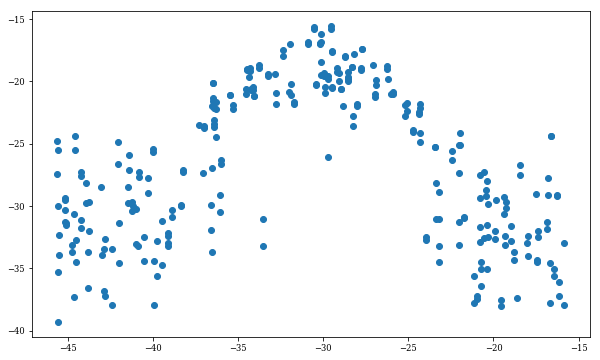

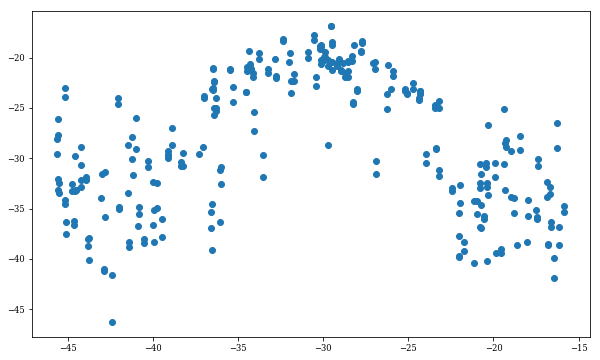

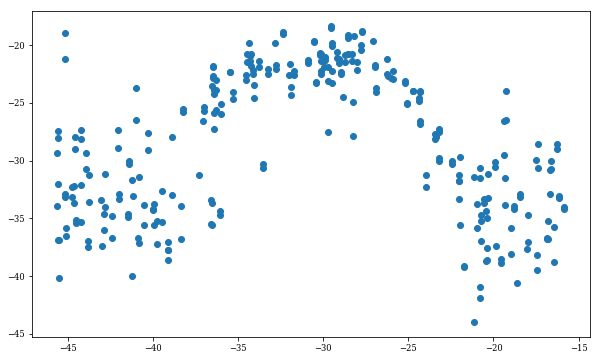

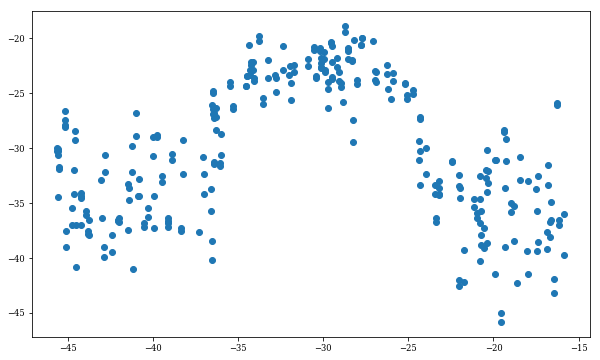

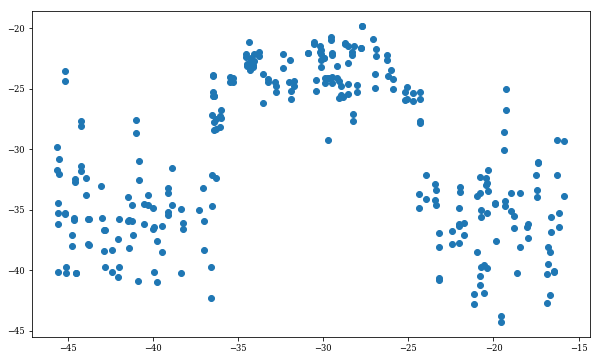

In [51]:
for i, track in enumerate(tracks):
    plt.figure(figsize=(10,6))
    plt.scatter(track_pos[i],10*np.log10(track))
    plt.show()

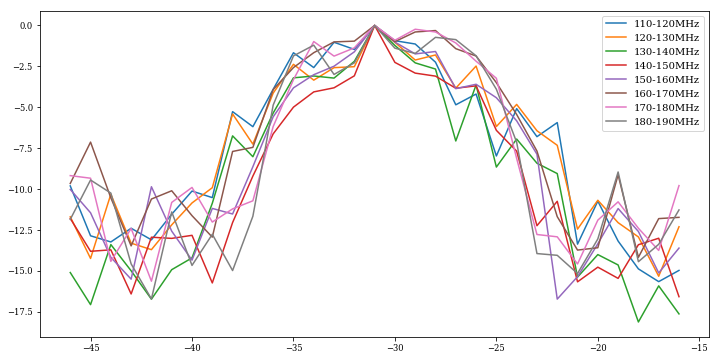

In [68]:
plt.figure(figsize=(12,6))

for i, track in enumerate(tracks_gridded):
    #plt.errorbar(tracks_gridded_ang[i],10*np.log10(track),yerr=tracks_gridded_std[i])
    plt.plot(tracks_gridded_ang[i],10*np.log10(track/track.max()), label = file_groups[i])
plt.legend()
plt.show()

In [69]:
hera_beam = UVBeam() #Instantiating HERA's beam as a UVBeam object
hera_beam.read_beamfits("NF_HERA_power_beam_healpix.fits") #Reading in the beam model
nside = hera_beam.nside #Setting the nside variable to be used in plotting

In [70]:
def beam_factor_2D(ra, dec, hera_zen_ra, freq):
    """
    Outputs the beam factor of an objects's specified RA and Dec.
    Args:
    'ra'          : Object's Right Ascension in degrees
    'dec'         : Object's Declination in degrees
    'hera_zen_ra' : HERA's Zenith Right Ascension for the specific JDate in degrees
    'freq'        : The frequency we want to analyze (interger)
    """
    hera_ra    = ra                                    #RA as seen by HERA
    hera_dec   = np.abs(dec)                           #Dec as seen by HERA
    rel_dec    = hera_dec - 30.72152612068925          #Finding relative Dec at HERA
    rel_ra     = np.abs(hera_ra - hera_zen_ra)         #Finding relative RA at HERA
    np_dec     = 90.0 - np.abs(rel_dec)                #Finding corresponding North Pole Dec
    np_ra      = rel_ra                                #Finding corresponding North Pole RA
    
    freq           = freq - 100                           #Changing the freq to array element
    beam_map       = hera_beam.data_array[0][0][0][freq]  #Selecting specified frequency
    beam_map_norm  = beam_map/np.max(beam_map)            #Normalizing values of beam model
    
    #Finding pixel value @ specified coords.
    return hp.get_interp_val(beam_map_norm,np_ra,np_dec, lonlat=True)

In [71]:
hera_dec = -30.72152612068925

diff = 15

n = 100

source_pos = np.linspace(hera_dec-diff,hera_dec+diff,n)

freq_ranges = [[110,120],[120,130],[130,140],[140,150],[150,160],[160,170],[170,180],[180,190]]

beams = []

for freq_set in freq_ranges:
    print freq_set
    freqs = np.arange(freq_set[0],freq_set[1])
    freq_beam = np.zeros(n)
    for j,freq in enumerate(freqs):
        temp = np.zeros(n)
        store = []
        for i in source_pos:
            store.append(beam_factor_2D(0, i, 0, freq))  
        freq_beam += np.array(store)
    freq_beam /= freqs.shape[0]
    beams.append(freq_beam)

[110, 120]
[120, 130]
[130, 140]
[140, 150]
[150, 160]
[160, 170]
[170, 180]
[180, 190]


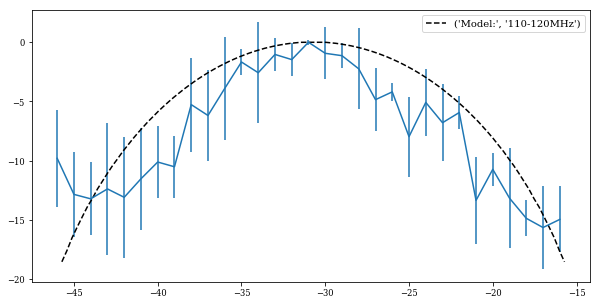

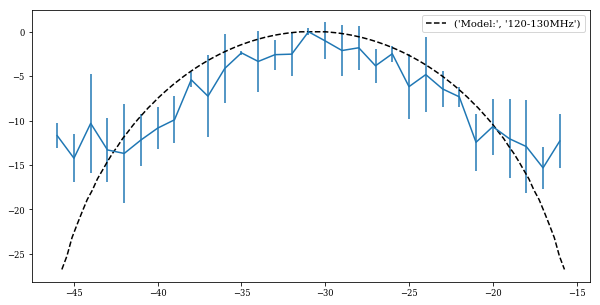

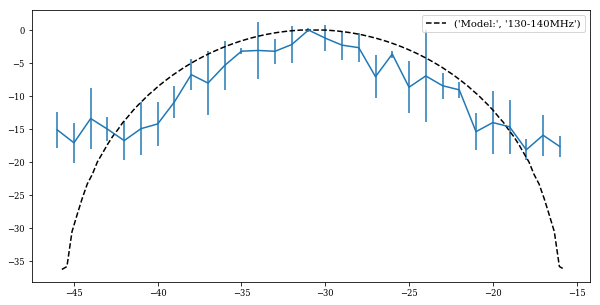

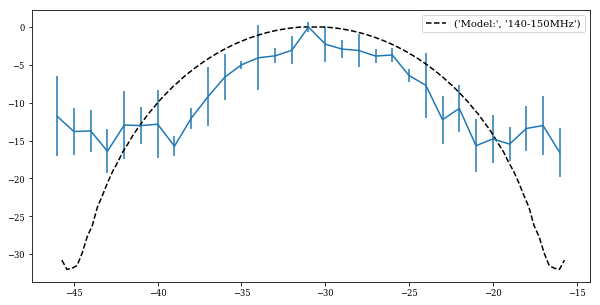

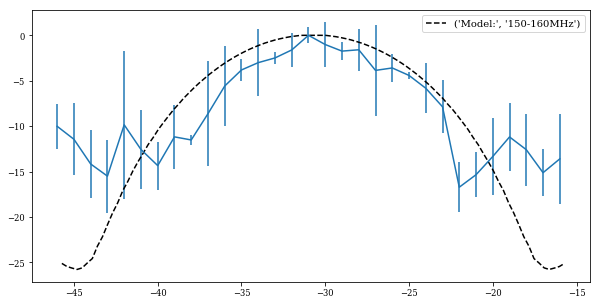

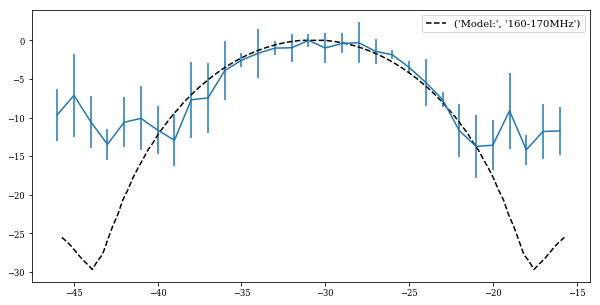

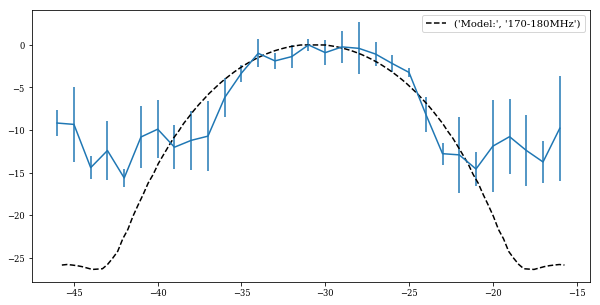

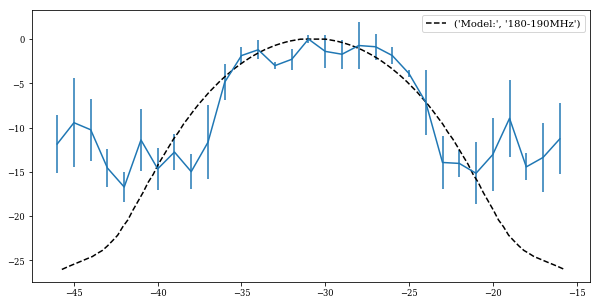

In [75]:
for i,beam in enumerate(beams):
    plt.figure(figsize=(10,5))
    plt.plot(source_pos,10*np.log10(beam),'k--',label=('Model:', file_groups[i]))
    plt.errorbar(tracks_gridded_ang[i],10*np.log10(tracks_gridded[i]/tracks_gridded[i].max()),yerr=tracks_gridded_std[i])
    plt.legend()
    plt.show()

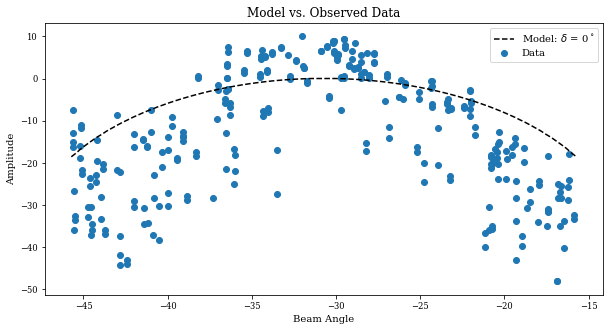